# 26회차 기출문제

In [2]:
import koreanize_matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## 문제 2 (25회 기출)

**Data description**

우리나라에 입국한 관광객 수에 관한 데이터입니다.

-   train : 1981.1 \~ 1991.12
-   test : 1992.1 \~ 1992.12

In [3]:
df= pd.read_csv('problem2.csv')
# # 월별 데이터 
# seasonal_period = 12

In [4]:
df = df.rename(columns = {'index' : 'date'})
df['date'] = pd.to_datetime(df['date'], format = '%Y %b') # 영어 월 요약 :b

import datetime
df['date'] = df['date'].dt.strftime('%Y-%m') # 월을 숫자로 변환
df.index = df['date']
df = df.drop(['date'], axis = 1)

In [5]:
df.tail()

,value
date,
1992-08,313671.0
1992-09,253522.0
1992-10,285057.0
1992-11,256798.0
1992-12,236805.0


1.  **데이터를 탐색하시오.**

In [6]:
df.isnull().sum()

value    4
dtype: int64

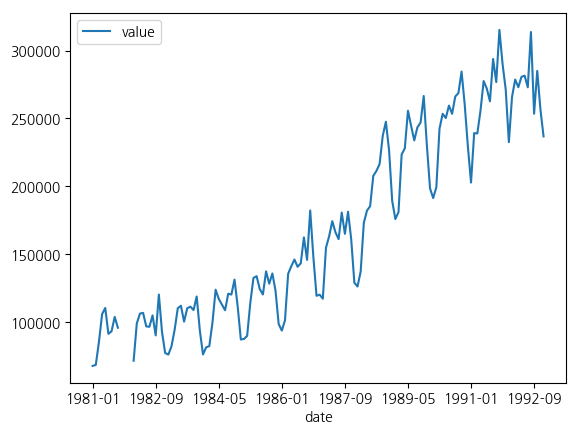

1981.10 ~ 1981.12에 결측치가 존재한다.


In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
df.plot();
plt.show();
print("1981.10 ~ 1981.12에 결측치가 존재한다.")

1. 추세가 존재
2. 계절성(Seasonality) 존재 

추세 그래프를 보면 시간이 지남에 따라 관광객 수가 증가하는 양의 추세가 확인할 수 있다. 또한, ACF가 천천히 감소하는 패턴을 보았을 때, 추세가 존재하는 것을 확인할 수 있다.

또한, 시간이 지남에 따라 분산이 증가하는 것으로 보이며, 분산 안정화 변환을 고려할 수 있다. 각 연도별 시계열 그래프를 보았을 때, 각 연도별로 비슷한 패턴이 반복되므로, 계절 추세가 존재한다.

2.  **결측치 확인 및 결측치를 대치하시오.**

훈련 데이터와 테스트 데이터를 분리한다.



In [8]:
TEST_SIZE = 12

train = df.iloc[:-TEST_SIZE]
test = df.iloc[-TEST_SIZE:]

In [9]:
train['value'] = train['value'].interpolate(method='linear')

선형 외삽 방법을 통해 결측치를 대치한다. 선형 외삽은 결측치 주변 실제값 사이의 관계를 이용하므로 시계열의 경향성을 반영하여 결측치를 대치하는 장점이 있다.

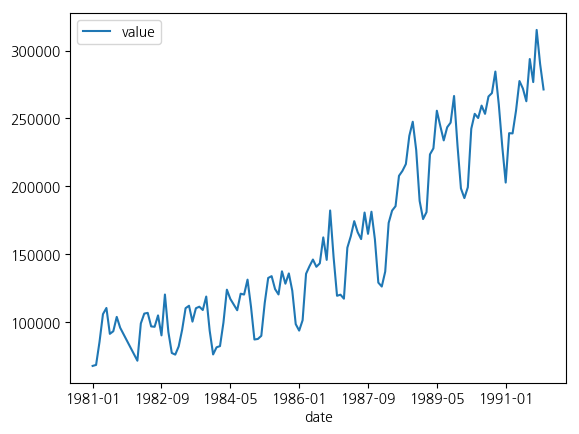

그림을 통해서 확인해본 결과, 시계열의 경향성을 반영하여 결측치가 대치된 것을 확인할 수 있다.


In [10]:
train.plot();
plt.show();
print("그림을 통해서 확인해본 결과, 시계열의 경향성을 반영하여 결측치가 대치된 것을 확인할 수 있다.")

1. 추세(Trend) 존재
    - 전반적으로 시간이 지날수록 값이 상승하고 있음 (우상향).
2. 분산 증가 (Heteroscedasticity)
    - 과거에 비해 변동폭이 커짐 : 분산이 시간에 따라 증가 → 분산 불균일성 → 비정상성
3. 계절성(Seasonality) 있음
    - 일정한 주기를 두고 파형이 반복되는 경향이 보임 → 계절 요인도 존재 가능 (연간 반복 패턴)
    
- 계절성 주기 s 값
    - 월별 데이터 : 12 (1년 = 12개월)
    - 주간 데이터 : 52 (1년 ≈ 52주)
    - 일별 데이터 : 7 (1주일), 365 (1년)
    - 분기별 데이터 : 4 (1년 = 4분기)


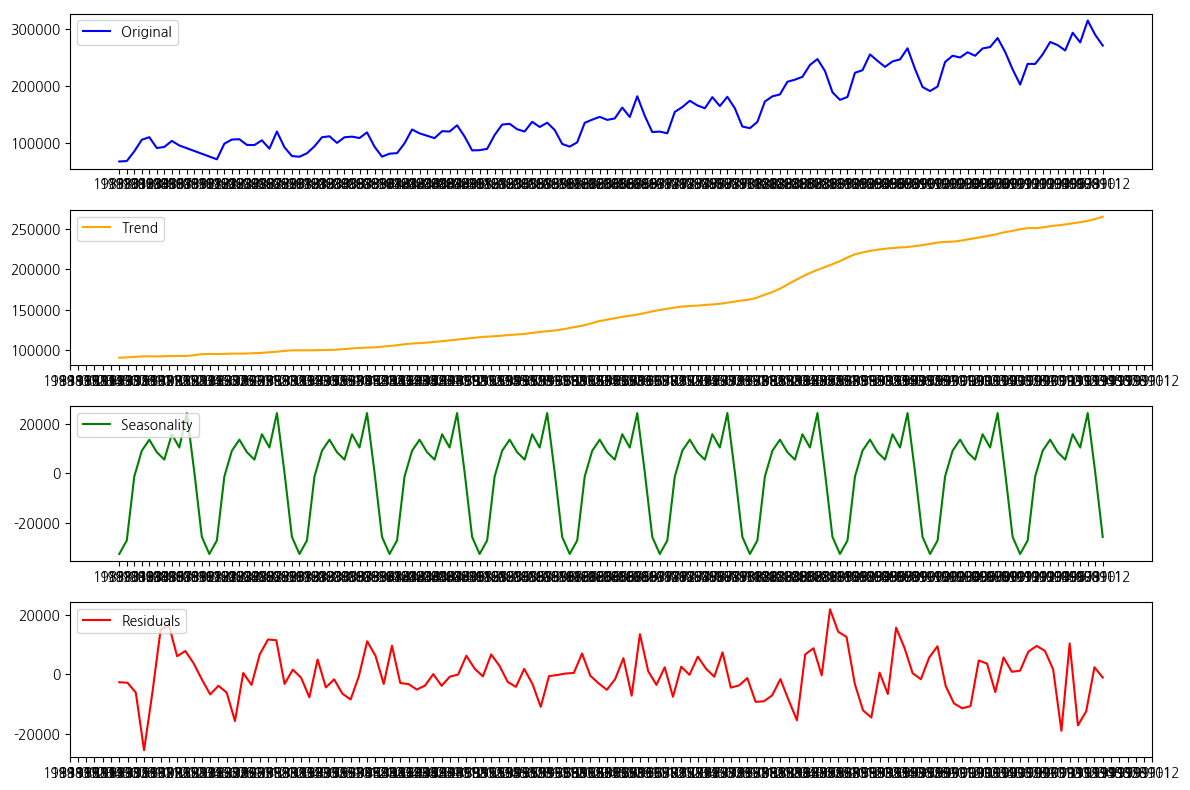


전체적으로 우상향하며 증가하는 추세를 보이며, 고정된 주기로 반복되는 패턴을 보이므로 trend와 seasonality(계절성)이 존재한다.
전체적으로 랜덤성 있는 노이즈 형태로 정상적인 잔차 구조를 가지는 것을 보인다.



In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = train['value']

# series: 시계열 데이터 (예: train['value'])
# 주기 (period)는 데이터 특성에 따라 설정 → 월별이면 12, 분기면 4 등
result = seasonal_decompose(series, model='additive', period=12)

# 시각화
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed, label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
print('''
전체적으로 우상향하며 증가하는 추세를 보이며, 고정된 주기로 반복되는 패턴을 보이므로 trend와 seasonality(계절성)이 존재한다.
전체적으로 랜덤성 있는 노이즈 형태로 정상적인 잔차 구조를 가지는 것을 보인다.
''')

## 3. 계절성을 포함하는 시계열 모델을 구축하고 정확도 측면에서 제시하시오.

**ARIMA의 본질은 정상성 시계열을 전제로 한 모델이므로 정상성을 확인해야한다.**
- p-value < 0.05: 귀무가설 기각 → 정상성 있음
- p-value ≥ 0.05: 정상성 없음 → 차분 필요

### **로그 변환은 반드시 차분 전에 먼저 해야 한다.**
1. **추세 (Trend)**
    - 평균이 시간에 따라 변함  
    ➤ 차분 (differencing)
2. **분산 불균일 (Heteroscedasticity)**
    - 시점에 따라 데이터 폭이 달라짐  
    ➤ 로그 변환 / Box-Cox 변환
3. **계절성 (Seasonality)**
    - 일정 주기의 반복 패턴 존재  
    ➤ 계절 차분 / 계절 조정

**계절 차분을 먼저 하고 → 그 결과에 1차 차분을 적용”하는 것이 통계적으로 권장되는 순서**

**SARIMA 모형을 설계하는 과정**

1. 시계열 plot을 보고 추세 및 계절성 존재 여부를 판단 (ACF를 보고 계절성 lag 수 결정)
    - 추세 X / 계절성 O : 해당 주기에 맞추어 차분 실시
    - 추세 O / 계절성 X : 선형 추세 > 1차 차분 / 곡선 형태 추세 > 함수 변환
    - 추세 O / 계절성 O : 계절성 차분을 한 후 추세를 다시 검토, 추세가 남아있는 경우 1차 차분 실시
2. ACF와 PACF로 p, q, P, Q 결정
    - p, q : ARIMA 모형과 동일
    - P, Q : 주시의 배수에서 나타나는 ACF, PACF로 결정
3. 성능 기준 최종 파라미터 추정
4. 잔차 검정

- 원본 데이터

In [12]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series) 
print(f"p-value: {adf_result[1]}")  # p < 0.05 이면 정상성 있음
print('유의수준 0.05에서 귀무가설을 기각하여 정상성을 만족하지 않는다.')

p-value: 0.9958854424397772
유의수준 0.05에서 귀무가설을 기각하여 정상성을 만족하지 않는다.


- 계절성 차분

In [13]:
series_season_diff = series.diff(12).dropna()
adf_result = adfuller(series_season_diff)
print(f"1차 차분 ADF p-value: {adf_result[1]}")  # 1차 차분

1차 차분 ADF p-value: 0.5054116609118182


- 로그 변환 후 계절성 차분
- 계절성 차분 : diff(12)- 월 간격으로 측정됨

In [14]:
import numpy as np
series_log = np.log(series)

# 로그 후 차분
series_log_season = series_log.diff(12).dropna()
adf_result = adfuller(series_log_season)
print(f"로그변환 후 1차 차분 ADF p-value: {adf_result[1]}")
print("유의수준 5%에서 귀무가설을 기각하므로 정상성을 만족할 수 없다고 결론내린다")

로그변환 후 1차 차분 ADF p-value: 0.21083100340662703
유의수준 5%에서 귀무가설을 기각하므로 정상성을 만족할 수 없다고 결론내린다


- 계절성 차분까지 확인 : diff(12)- 월 간격으로 측정됨

- 로그변환 후 계절성 차분 + 1차 차분

In [15]:
series_seasonal_diff = series_log_season.diff().dropna()

adf_result = adfuller(series_seasonal_diff)
print(f"1차 차분 + 계절성 차분 ADF p-value: {adf_result[1]}")
print("유의수준 5%에서 p-value = 0.000으로 귀무가설을 기각할 수 없으므로 정상성을 만족한다고 결론내린다.")

1차 차분 + 계절성 차분 ADF p-value: 1.487655536784364e-05
유의수준 5%에서 p-value = 0.000으로 귀무가설을 기각할 수 없으므로 정상성을 만족한다고 결론내린다.


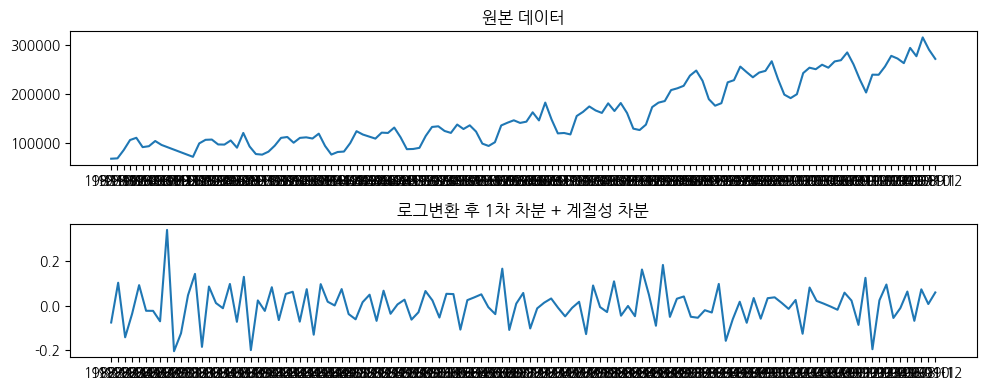

In [16]:
# 추세가 점진적이거나 비선형적인가?
# 계절성이 존재하는가?
# 분산이 시간이 지남에 따라 증가하는가?
# → 분산이 점점 커진다면 로그 변환(log) 또는 Box-Cox 변환 등을 고려
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
axes[0].plot(series); axes[0].set_title('원본 데이터')
axes[1].plot(series_seasonal_diff); axes[1].set_title('로그변환 후 1차 차분 + 계절성 차분')
plt.tight_layout(); plt.show()

로그 변환 후 계절성 차분, 1차 차분한 결과, 시간에 따라 분산이 일정하게 안정화된 것을 확인할 수 있다.

**ACF, PACF그래프**
- ACF/PACF 그래프는 반드시 **“정상성을 만족하는 데이터”**에서 봐야함
- 즉, 로그 변환만 한 비정상 시계열이 아니라, 차분 후 정상화된 시계열을 기반으로 봐야함.

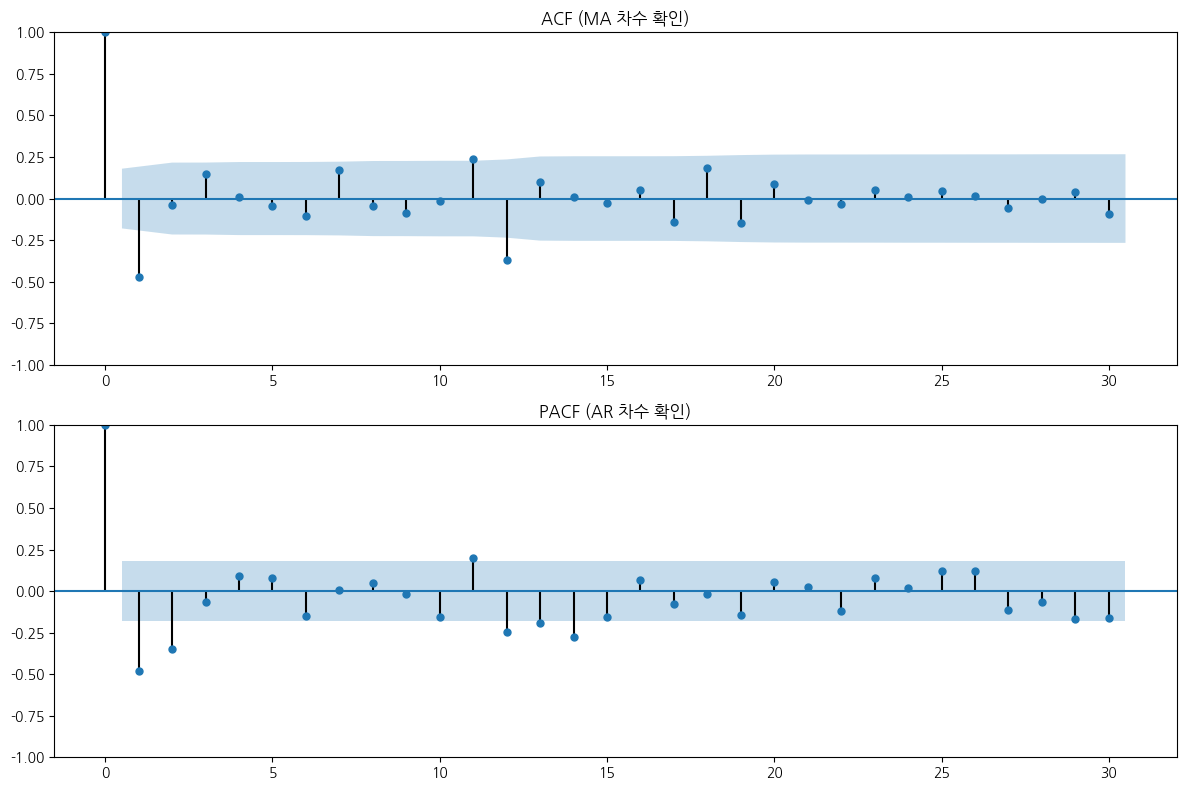


ACF 그래프에서 lag=12에서 피크를 보이고, PACF 그래프에서 lag=12에서 피크를 보이므로 Q=1,P=1 이다. 
따라서 seasonal_order=(1, 1, 1, 12)로 설정한다.



In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plot_acf(series_seasonal_diff, lags=30, ax=plt.gca(), title="ACF (MA 차수 확인)")

plt.subplot(212)
plot_pacf(series_seasonal_diff, lags=30, ax=plt.gca(), title="PACF (AR 차수 확인)")
plt.tight_layout()
plt.show()

print('''
ACF 그래프에서 lag=12에서 피크를 보이고, PACF 그래프에서 lag=12에서 피크를 보이므로 Q=1,P=1 이다. 
따라서 seasonal_order=(1, 1, 1, 12)로 설정한다.
''')

In [18]:
import pmdarima as pm

model = pm.auto_arima(
    series_log, 
    start_p=0, 
    start_q=0,
    max_p=5, 
    max_q=5,
    m=12,                   # 계절 주기 (월별이면 12)
    d=1,                    # 비계절 차분 횟수 (일반 차분)
    seasonal=True,          # 계절성 모델 (SARIMA)
    start_P=0, 
    D=1,                    # 계절 차분 횟수
    trace=True,             # 학습 과정 출력
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True           # stepwise 탐색 (속도 빠름)
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-282.638, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-250.935, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-302.540, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-318.098, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-290.045, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-317.983, Time=0.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-317.830, Time=0.60 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-317.285, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-317.159, Time=0.91 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-316.294, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-316.403, Time=0.36 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-305.332, Time=0.12 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-314.607, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-316.416, Time=0.30 sec

Best model:  ARIMA

**ARIMA(0,1,1)(1,1,1)[12] 를 최종 모형으로 선택한다. 모델에 대한 가정을 검토한다.**
* -2 log(L) : 가능도가 높을수록 AIC가 낮아짐
* 2 (p+q+k+1) : 모형의 복잡도로 이 복잡도가 커질수록 AIC가 높아짐

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(series_log, 
                order=(0, 1, 1), 
                seasonal_order=(1, 1, 1, 12), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13715D+00    |proj g|=  4.09632D+00

At iterate    5    f= -1.17260D+00    |proj g|=  3.59060D-01

At iterate   10    f= -1.18071D+00    |proj g|=  1.40132D-01

At iterate   15    f= -1.18420D+00    |proj g|=  7.32842D-01

At iterate   20    f= -1.18538D+00    |proj g|=  1.35468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   2.301D-05  -1.185D+00
  F =  -1.1853815350995016     

CONVERG

 This problem is unconstrained.


In [463]:
# 계수 유의성 (p-value < 0.05) : 중요하지만 2차적
# 잔차 자기상관 없음 : 가장 중요

- 귀무가설(H₀): 잔차에 자기상관이 없다 (white noise이다)
- 대립가설(H₁): 잔차에 자기상관이 있다 (white noise가 아니다)

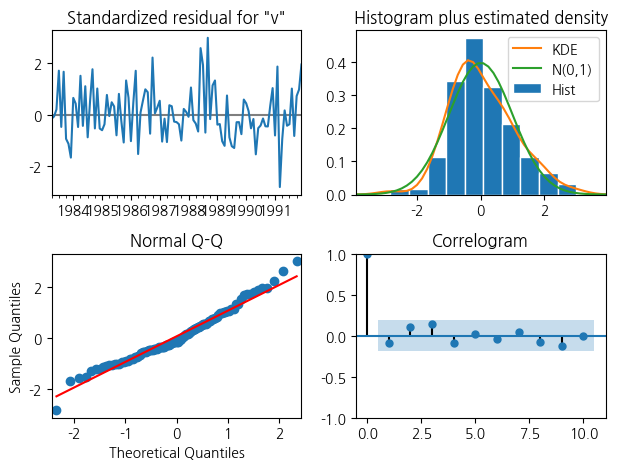

In [20]:
results.plot_diagnostics();
plt.tight_layout()
plt.show();

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results.resid

# Ljung-Box 검정 (lags=12: 계절성 포함 여부 보기 좋음)
ljung_result = acorr_ljungbox(residuals, lags=[12], return_df=True)

print("Ljung-Box Q 검정 결과:")
print(ljung_result)
print(''' 
ljung box 테스트 결과 유의수준 0.05에서 p-value = 0.054이므로 귀무가설을 기각할 수 없다. 
따라서 잔차 사이에 자기상관이 존재하지 않는다. 잔차의 그래프를 보면 뚜렷한 경향성이 없고, 0을 중심으로 무작위로 분포한다.
추가적으로 잔차의 분포를 확인했을 때, 근사적으로 정규분포의 형태를 띄므로, 오차의 정규성 가정을 만족한다고 할 수 있다.
''')

Ljung-Box Q 검정 결과:
      lb_stat  lb_pvalue
12  20.775322   0.053769
 
ljung box 테스트 결과 유의수준 0.05에서 p-value = 0.054이므로 귀무가설을 기각할 수 없다. 
따라서 잔차 사이에 자기상관이 존재하지 않는다. 잔차의 그래프를 보면 뚜렷한 경향성이 없고, 0을 중심으로 무작위로 분포한다.
추가적으로 잔차의 분포를 확인했을 때, 근사적으로 정규분포의 형태를 띄므로, 오차의 정규성 가정을 만족한다고 할 수 있다.



In [466]:
# 여러개 해서 맞춰보기
# 아니면 통계적 검정에서 과도한 기각이 발생할 수 있음을 고려하여, 유의수준을 1%으로 설정하였다. 
result = acorr_ljungbox(residuals, lags=range(1, 25), return_df=True)
print(result)

      lb_stat  lb_pvalue
1    0.006018   0.938166
2    0.037720   0.981317
3    0.088569   0.993173
4    0.101190   0.998762
5    0.146013   0.999589
6    0.146295   0.999938
7    0.183626   0.999981
8    0.185353   0.999997
9    0.256124   0.999998
10   0.257984   1.000000
11   0.260337   1.000000
12  20.775322   0.053769
13  20.788841   0.077211
14  20.818001   0.106388
15  20.825748   0.142490
16  20.826010   0.185296
17  20.826750   0.234136
18  20.829137   0.288121
19  20.829636   0.346290
20  20.847325   0.406167
21  20.927038   0.463408
22  20.957927   0.523340
23  20.960978   0.583471
24  22.380440   0.556571


### 예측 성능 확인

훈련 데이터와 테스트 데이터의 모델 성능은 다음과 같다.

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 예측 수행 (steps = test 기간 길이만큼)
forecast_log = results.get_forecast(steps=TEST_SIZE)
forecast_log_mean = forecast_log.predicted_mean

# 2. 로그 되돌리기 (예측값과 실제값 모두)
forecast = np.exp(forecast_log_mean)
actual = test['value']


# 3. 정확도 평가
mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

MAE  : 40710.27
RMSE : 48161.29


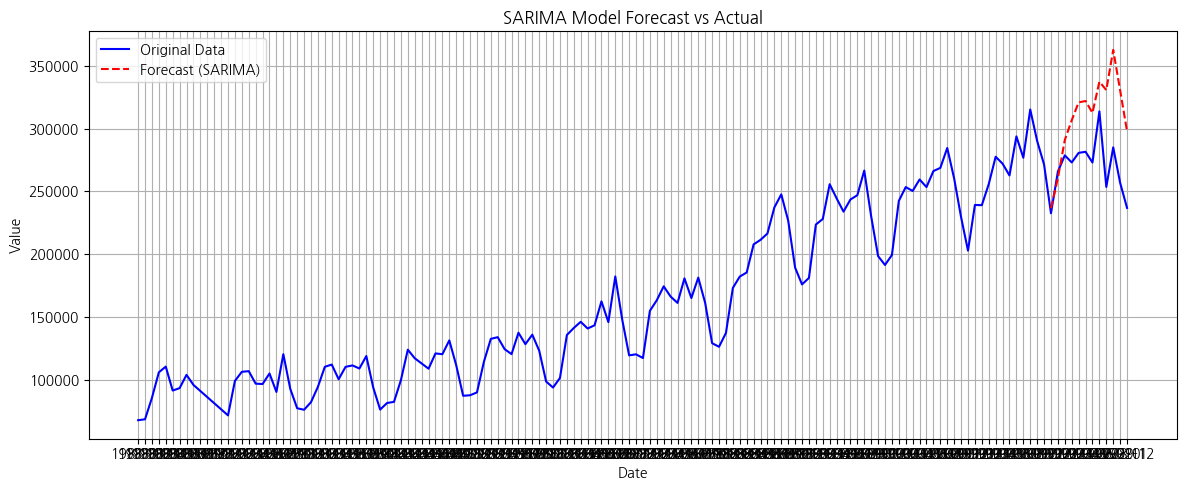

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 1. 전체 시계열 데이터
plt.plot(df.index, df['value'], label='Original Data', color='blue')
# 2. SARIMA 예측 결과 (로그 역변환된 예측)
plt.plot(test.index, forecast, label='Forecast (SARIMA)', color='red', linestyle='--')

# 3. 시각적 꾸미기
plt.title('SARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4.  **업무에 적용할 수 있는지, 판단근거와 함께 서술하시오.**

## 문제 3(변형 문제)

**별도의 데이터 없음**

돈돈이는 사회학 연구소에서 연구원으로 일하고 있습니다. 그는 직업 만족도가 사람들의 수입 수준에 따라 어떻게 달라지는지 궁금했습니다. 이를 위해 도시에서 일하는 96명의 사람들을 대상으로 설문조사를 진행했습니다. 설문조사에서는 응답자들의 수입과 직업 만족도에 대해 물어보았고, 그 결과는 다음과 같았습니다.

|                   |                      |                 |               |               |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
| 수입\\직업만족도  | **VD (매우 불만족)** | LD(조금 불만족) | MS(조금 만족) | VS(매우 만족) |
|   **\<15,000**    |          1           |        3        |      10       |       6       |
| **15,000-25,000** |          2           |        3        |      10       |       7       |
| **25,000-40,000** |          1           |        6        |      14       |      12       |
|   **\>40,000**    |          0           |        1        |       9       |      11       |


1.  **수입 수준과 직업 만족도 간의 순위 관계를 파악하기 위해 Goodman and Kruskal의 Gamma 계수를 계산하시오.**

In [3]:
from scipy.stats import gamma as goodman_kruskal_gamma

# 교차표 데이터 
df =  pd.DataFrame({
    'VD': [1, 2, 1, 0],
    'LD': [3, 3, 6, 1],
    'MS': [10, 10, 14, 9],
    'VS': [6, 7, 12, 11]
}, index=['<15,000', '15,000-25,000', '25,000-40,000', '>40,000'])
df

,VD,LD,MS,VS
"<15,000",1,3,10,6
"15,000-25,000",2,3,10,7
"25,000-40,000",1,6,14,12
">40,000",0,1,9,11


In [5]:
# 행과 열에 순위 부여 1부터 시작
row_ranks = np.arange(1, 5) # 행 순위
col_ranks = np.arange(1, 5)

**Gamma 계수란?**
- 두 순서형 변수 간의 순위 상관관계를 측정하는 지표
    - γ = (C - D) / (C + D)
    - C: 일치쌍 (두 변수 모두 증가하거나 감소)
	- D: 불일치쌍 (한 변수는 증가하고 다른 변수는 감소)

**일치쌍** : C
- 조건: i < k and j < l
    - → 첫 번째 사람이 수입도 낮고, 만족도도 낮다
    - → 두 번째 사람이 수입도 높고, 만족도도 높다
    - 즉, 두 변수 모두 같은 방향으로 증가
    
**불일치쌍** : D
- 조건: i < k and j > l
	- → 첫 번째 사람은 수입은 낮지만 만족도는 높음
    - → 두 번째 사람은 수입은 높지만 만족도는 낮음
	- 즉, 두 변수의 변화 방향이 반대

In [6]:
C = 0
D = 0

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        for k in range(df.shape[0]):
            for l in range(df.shape[1]):
                if i < k and j < l: 
                    C += df.iloc[i,j] * df.iloc[k,l]
                elif i <k and j > l : 
                    D += df.iloc[i,j] * df.iloc[k,l]
                    

In [7]:
# gamma 계산
gamma = (C - D) / (C + D) if (C + D) != 0 else 0


In [9]:
print(gamma, C, D)
print("gamma계수가 0.221로 약한 양의 순서 관계가 존재한다.")

0.22110091743119267 1331 849
gamma계수가 0.221로 약한 양의 순서 관계가 존재한다.


2.  **5% 유의수준
에서 가설 검증에 대한 검정통계량을 계산하시오. (단, 반올림하여 소수점 셋째 자리까지 표시하시오.) 연구가설의 채택여부를 결정하시오.**


- 귀무가설 $H_0$: 수입과 직업 만족도 사이에 순서상 관련이 없다 → $\gamma = 0$
- 대립가설 $H_1$: 수입과 직업 만족도 사이에 순서상 관련이 있다 → $\gamma \ne 0$

$Z = \frac{\gamma}{\sqrt{\frac{1 - \gamma^2}{N}}}$

In [13]:
from scipy.stats import norm
N = C + D
z = gamma/np.sqrt((1-gamma**2)/N)
p_value = 2*norm.sf(abs(z)) # sf = 1- cdf

print("검정통계량 Z :", z)
print("p-value : ",p_value)
print('''
p-value = 0.000 이므로 귀무가설을 기각한다. 
따라서 수입이 증가할수록 직업만족도가 높아지는 경향이 통계적으로 유의하다고 볼 수 있다 ''')

검정통계량 Z : 10.585281611766357
p-value :  3.487305245242973e-26

p-value = 0.000 이므로 귀무가설을 기각한다. 
따라서 수입이 증가할수록 직업만족도가 높아지는 경향이 통계적으로 유의하다고 볼 수 있다 



## 문제 4

**별도의 데이터 없음**

슬통 전구회사는 자사의 제품 생산 라인에서 최근 불량률이 급증했다는 내부 보고서를 받았습니다. 초기 보고서에 따르면 불량률이 약 9%에 달한다고 합니다. 회사의 경영진은 이를 확인하기 위해 독립적인 품질 검사팀에 조사를 의뢰하였습니다. 검사팀은 신뢰도 95%로 불량률을 확인하기 위해 필요한 표본 크기를 계산하고자 합니다. 오차한계가 3% 내외로 허용된다면, 검사팀은 최소 몇 개의 제품을 표본으로 선택해야 하는지 계산하시오.

$n = \left( \frac{Z^2 \cdot p \cdot (1 - p)}{E^2} \right)$
- Z = 1.96 (신뢰수준 95%)
- p = 0.09 (불량률)
- E = 0.03 (허용 오차)

In [15]:
Z = 1.96
p = 0.09
E = 0.03

n = (Z**2 * p * (1-p) )/ (E**2)
sample_size = np.ceil(n) 

print(int(sample_size))

350




## 문제 5(변형 문제)

**별도의 데이터 없음**

돈돈이는 사회학을 공부하는 대학생으로, 학력 수준에 따라 사람들이 어떤 종교적 신념을 가지고 있는지 궁금해졌습니다. 이를 알아보기 위해, 도시에서 일하는 2726명의 사람들을 대상으로 설문조사를 진행했습니다. 설문조사 응답 결과를 정리한 자료는 다음과 같습니다.

| 학위\\종교적 믿음 | 원리주의자 | 중도 | 원칙주의자 |
|-------------------|------------|------|------------|
| 고졸              | 178        | 138  | 108        |
| 전문대졸          | 570        | 648  | 442        |
| 대졸              | 138        | 252  | 252        |



1.  **5% 유의수준에서 가설 검증에 대한 검정통계량을 계산하시오. (단, 반올림하여 소수점 셋째 자리까지 표시하시오.) 연구가설의 채택여부를 결정하시오.**

- 귀무가설 : 학력 수준과 종교적 신념은 독립이다.
- 대립가설 : 학력 수준과 종교적 신념은 독립이 아니다

In [16]:
from scipy.stats import chi2_contingency

tt = np.array([[178, 138, 108],
               [570, 648, 442],
               [138, 252, 252]])

In [20]:
chi2, p, dof, expected = chi2_contingency(tt)

print(chi2)
print(p)
print('''
유의수준 5%에서 p-value = 0으로 매우 작으므로 귀무가설을 기각한다.
따라서 학력수준과 종교적 신념은 서로 독립이 아니다. ''')

69.15675936513162
3.419689510099415e-14

유의수준 5%에서 p-value = 0으로 매우 작으므로 귀무가설을 기각한다.
따라서 학력수준과 종교적 신념은 서로 독립이 아니다. 


2.  **검정 결과에 대한 잔차분석을 수행하고, 해석하시오.**

**잔차(residual) 분석이란?**
- 잔차(Residual) = 관측도수 − 기대도수
- 표준화 잔차(Standardized Residual) =$\frac{O - E}{\sqrt{E}}$ (O: 관측값, E: 기대값)
- 절대값이 2 이상이면 유의하게 큰 차이로 간주 (기대값 대비 관측값이 많거나 적음)

In [21]:
residuals = (tt - expected)/np.sqrt(expected)
residuals = residuals.round(2)

In [23]:
pd.DataFrame(residuals, index = ['고졸','전문대졸','대졸'], columns =['원리주의자',\
                                                              '중도','원칙주의자'] )

,원리주의자,중도,원칙주의자
고졸,3.42,-1.85,-1.50
전문대졸,1.31,0.63,-2.10
대졸,-4.89,0.48,4.59


고졸자는 원리주의자일 확률이 유의하게 높다. 
전문대졸자는 원칙주의자일 확률이 유의하게 낮다. 
대졸자는 원리주의자일 확률이 유의하게 낮다. 
대졸자는 원칙주의자일 확률이 유의하게 높다.



## 문제 6

슬통 초등학교에서는 학생들의 건강 관리를 위해 일부 학생들의 혈압을 측정하였습니다. 총 25명의 학생 중 남학생은 16명, 여학생은 9명이었습니다. 학교 건강 관리팀은 남학생과 여학생 사이에 평균 혈압이 차이가 있는지 궁금해하였고, 이를 확인하기 위해 5%의 유의수준에서 검정하려 합니다. (단, 남녀 학생의 혈압이 정규분포를 따르며, 두 집단의 분산이 동일하다고 가정합니다.)

In [34]:
df = pd.read_csv('problem6.csv')
df

,No.,남학생,여학생
0,1,124.97,114.87
1,2,118.62,128.14
2,3,126.48,115.92
3,4,135.23,110.88
4,5,117.66,139.66
5,6,117.66,122.74
6,7,135.79,125.68
7,8,127.67,110.75
8,9,115.31,119.56
9,10,125.43,NaN


남학생과 여학생의 평균 혈압 차이를 5% 유의수준에서 검정
- 가정
	- 두 집단은 **정규분포**를 따른다.
	- 두 집단은 **등분산성**을 만족한다

1)  **연구가설과 귀무가설 작성하시오.**


- 귀무가설 : 남학생과 여학생의 평균 혈압은 차이가 없다. 
- 대립가설 : 남학생과 여학생의 평균 혈압은 차이가 있다. 


2)  **가설검증에 대한 검정통계량을 계산하고, 연구가설의 채택여부를 설명하시오.**

In [35]:
from scipy.stats import ttest_ind

f = df['여학생'].dropna()
m  = df['남학생'].dropna()

# 등분산 가정 하에서 독립 2표본 t-검정 
t_stat, p = ttest_ind(m,f, equal_var= True)

print(t_stat)
print(p)
print(
'''
독립표본 t-검정을 실시한 결과, 남학생과 여학생 간의 평균 혈압 차이에 대한 p-value 는 약 0.77으로 유의수준 
5% 에서 통계적으로 유의하지 않다. 
따라서 평균 혈압의 차이가 통계적으로 유의하지 않다
''')

-0.2916437301483526
0.7731732568629174

독립표본 t-검정을 실시한 결과, 남학생과 여학생 간의 평균 혈압 차이에 대한 p-value 는 약 0.77으로 유의수준 
5% 에서 통계적으로 유의하지 않다. 
따라서 평균 혈압의 차이가 통계적으로 유의하지 않다



3)  **가설검정에 대한 신뢰구간을 계산하고, 계산된 신뢰구간이 어떻게 2의 결과를 지지하는지 설명하시오.\
    (단, 신뢰구간 계산시 다음의 값을 사용하시오.)**

-   $t_{23,0.025} = 2.069$

두 집단의 평균 차이에 대한 신뢰구간 공식
- $(\bar{X}_1 - \bar{X}2) \pm t{\alpha/2} \cdot \sqrt{s_p^2 \left( \frac{1}{n_1} + \frac{1}{n_2} \right)}$


$s_p^2$: 공통 분산 (pooled variance)    
- $s_p^2 = \frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}$

In [36]:
n1 = len(m)
n2 = len(f)

mean1 = np.mean(m)
mean2 = np.mean(f)

var1 = np.var(m)
var2 = np.var(f)

sp = ((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2)

se = np.sqrt(sp*(1/n1 + 1/n2))
df = n1 + n2 - 2


from scipy.stats import t 
t_c = t.ppf(0.975, df)


mean_diff = mean1 - mean2
lower = mean_diff - t_c*se
upper = mean_diff + t_c*se

In [37]:
print(f"95% 신뢰구간 : ({lower},{upper})")

95% 신뢰구간 : (-9.091318885105686,6.76284666288347)
